In [1]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.pipeline import make_pipeline

import mlb_metrics_helpers

import pandas as pd

In [2]:
# get pitcher data
mikolaus_id = mlb_metrics_helpers.player_id("Mikolas", "Miles")
mikolaus_general_stats = mlb_metrics_helpers.player_general_metrics(
    mikolaus_id, timeline_type="career"
)
mikolaus_timeline = mlb_metrics_helpers.parse_career_timeline(mikolaus_general_stats)
mikolaus_specific_stats = mlb_metrics_helpers.player_specific_metrics(
    mikolaus_id,
    metric_type="pitching",
    start_dt=mikolaus_timeline[0],
    end_dt=mikolaus_timeline[1],
)

mikolaus_specific_stats

Gathering player lookup table. This may take a moment.
Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2018-05-04,94.2,-2.45,6.51,"Mikolas, Miles",592178,571945,double,hit_into_play,...,3,0,3,0,3,Standard,Standard,202.0,-0.053,0.718
1,CU,2018-05-04,78.3,-2.27,6.45,"Mikolas, Miles",592178,571945,NaN,called_strike,...,3,0,3,0,3,Standard,Standard,34.0,0.000,-0.051
2,SL,2018-05-04,86.3,-2.46,6.63,"Mikolas, Miles",592178,571945,NaN,called_strike,...,3,0,3,0,3,Standard,Standard,153.0,0.000,-0.036
3,SI,2018-05-04,93.2,-1.97,6.52,"Mikolas, Miles",450314,571945,field_out,hit_into_play,...,3,0,3,0,3,Standard,Standard,235.0,0.020,-0.255
4,CU,2018-05-04,77.5,-2.25,6.45,"Mikolas, Miles",450314,571945,NaN,ball,...,3,0,3,0,3,Standard,Standard,33.0,0.000,0.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13015,CU,2018-05-10,80.5,-2.14,6.54,"Mikolas, Miles",608671,571945,NaN,ball,...,1,1,0,0,1,Standard,Standard,28.0,0.000,0.043
13016,CU,2018-05-10,79.1,-2.12,6.42,"Mikolas, Miles",608671,571945,NaN,foul,...,1,1,0,0,1,Strategic,Standard,31.0,0.000,0.000
13017,FF,2018-05-10,97.1,-1.91,6.53,"Mikolas, Miles",608671,571945,NaN,ball,...,1,1,0,0,1,Standard,Standard,209.0,0.000,0.023
13018,FF,2018-05-10,94.4,-2.18,6.61,"Mikolas, Miles",608671,571945,NaN,foul_bunt,...,1,1,0,0,1,Standard,Standard,201.0,0.000,-0.051


In [3]:
mikolaus_specific_stats.zone.value_counts()

zone
14.0    3290
11.0    1754
5.0     1202
6.0     1185
12.0    1127
9.0      966
4.0      908
13.0     885
2.0      875
8.0      850
1.0      694
3.0      653
7.0      505
Name: count, dtype: int64

In [13]:
def model_metrics(player_specific_metrics: pd.DataFrame) -> pd.DataFrame:
    """
    Processes player-specific metrics for model training.

    Parameters:
        player_specific_metrics (pd.DataFrame): DataFrame containing player-specific metrics.

    Returns:
        pd.DataFrame: DataFrame prepared for batter model training (predict result of swing).
    """
    # columns to use as features and classes
    col_to_keep = [
        "pitch_type",
        "release_speed",
        "release_pos_x",
        "release_pos_y",
        "release_spin_rate",
        "spin_axis",
        "p_throws",
        # "plate_x",
        # "plate_z",
        "vx0",
        "vy0",
        "vz0",
        "ax",
        "ay",
        "az",
        "sz_top",
        "sz_bot",
        "zone",
    ]

    # Select only the relevant target columns
    batter_model_data = player_specific_metrics[col_to_keep]

    # Drop rows with missing values
    batter_model_data.dropna(inplace=True)

    return batter_model_data

model_stats = model_metrics(mikolaus_specific_stats)

model_stats

/var/folders/pc/dx9_5lnn3qz8j56zyhdcmk8w0000gn/T/ipykernel_78798/3905885531.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batter_model_data.dropna(inplace=True)


,pitch_type,release_speed,release_pos_x,release_pos_y,release_spin_rate,spin_axis,p_throws,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,zone
0,FF,94.2,-2.45,54.55,2319.0,202.0,R,9.733690,-136.547039,-8.347547,-8.977545,29.991442,-13.601673,3.27,1.44,14.0
1,CU,78.3,-2.27,55.67,2757.0,34.0,R,3.213866,-113.685528,0.330972,6.686118,23.277507,-43.409795,3.32,1.60,5.0
2,SL,86.3,-2.46,54.72,2371.0,153.0,R,5.640100,-125.479792,-4.522315,2.195190,23.817224,-25.240157,3.37,1.60,5.0
3,SI,93.2,-1.97,54.09,2351.0,235.0,R,7.685924,-135.392311,-7.774589,-18.646288,30.631840,-18.774989,3.47,1.54,8.0
4,CU,77.5,-2.25,55.18,2640.0,33.0,R,1.014720,-112.477903,2.890067,6.294862,22.392686,-43.087035,3.46,1.53,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13015,CU,80.5,-2.14,55.44,2600.0,28.0,R,5.529310,-116.837519,-5.378493,4.665743,23.929388,-42.397880,3.26,1.54,14.0
13016,CU,79.1,-2.12,54.36,2558.0,31.0,R,0.761371,-115.012096,0.239371,6.480165,24.726793,-43.542036,3.34,1.44,13.0
13017,FF,97.1,-1.91,54.09,2253.0,209.0,R,9.395963,-140.900648,-8.466190,-9.829562,31.611886,-16.812228,3.26,1.57,14.0
13018,FF,94.4,-2.18,54.32,2161.0,201.0,R,6.675660,-137.256735,-6.066099,-8.243672,30.168799,-13.864550,3.34,1.44,2.0


In [14]:
def model_datasets(
    model_data: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits the model data into training and testing datasets.

    Parameters:
        model_data (pd.DataFrame): DataFrame containing model data.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]: A tuple containing the training and testing datasets.
            - X_train (pd.DataFrame): Training feature dataset.
            - X_test (pd.DataFrame): Testing feature dataset.
            - y_train (pd.Series): Training class dataset.
            - y_test (pd.Series): Testing class dataset.
    """
    # metric we want to predict (swing result)
    target = "zone"

    # Split into feature and class datasets
    X = model_data.drop(columns=[target])
    y = model_data[target]

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, test_size=0.1, stratify=y
    )

    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = model_datasets(model_stats)

In [21]:
def trained_model(
    X_train: pd.DataFrame, y_train: pd.Series, sklearn_model: object
) -> object:
    """
    Trains a batter model using the provided training data.

    Parameters:
        X_train (pd.DataFrame): Training feature dataset.
        y_train (pd.Series): Training class dataset.
        sklearn_model (object): Type of model to be trained.

    Returns:
        object
    """
    # Select numerical and categorical columns
    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(X_train)
    categorical_columns = categorical_columns_selector(X_train)

    # Preprocess categorical and numerical columns
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    preprocessor = ColumnTransformer(
        [
            ("one-hot-encoder", categorical_preprocessor, categorical_columns),
            ("standard_scaler", numerical_preprocessor, numerical_columns),
        ]
    )

    # Create and train the model
    model = make_pipeline(preprocessor, sklearn_model)
    model.fit(X_train, y_train)

    return model

model = trained_model(X_train, y_train, LogisticRegression())

/Users/roshankern/miniforge3/envs/mlb_metrics_backend/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
from typing import Literal


def tested_model(
    batter_model_data: pd.DataFrame,
    sklearn_model_type: Literal[
        "logistic_regression",
        "random_forest",
        "gradient_boosting",
        "hist_gradient_boosting",
    ],
) -> tuple[object, float]:
    """
    Trains and evaluates a batter model using the specified sklearn model type.

    Args:
        batter_model_data (pd.DataFrame): The input data for training the model.
        sklearn_model_type (Literal): The type of sklearn model to use. Must be one of:
            - "logistic_regression"
            - "random_forest"
            - "gradient_boosting"
            - "hist_gradient_boosting"

    Returns:
        tuple[object, float]: A tuple containing the trained model object and the accuracy score.
    """
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = model_datasets(batter_model_data)

    # Train the model
    if sklearn_model_type == "logistic_regression":
        model_type = LogisticRegression(random_state=0)
    elif sklearn_model_type == "random_forest":
        model_type = RandomForestClassifier(random_state=0)
    elif sklearn_model_type == "gradient_boosting":
        model_type = GradientBoostingClassifier(random_state=0)
    elif sklearn_model_type == "hist_gradient_boosting":
        model_type = HistGradientBoostingClassifier(random_state=0)
    else:
        raise ValueError(
            "Invalid sklearn_model_type. Please choose a valid model type."
        )

    model = trained_model(X_train, y_train, model_type)

    # Evaluate the model
    accuracy = model.score(X_test, y_test)

    return (model, accuracy)

sklearn_model_types = ["logistic_regression", "random_forest", "gradient_boosting", "hist_gradient_boosting"]
for model_type in sklearn_model_types:
    model, accuracy = tested_model(model_stats, model_type)
    print(f"{model_type} accuracy: {accuracy}")

/Users/roshankern/miniforge3/envs/mlb_metrics_backend/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression accuracy: 0.7721804511278195
random_forest accuracy: 0.6827067669172933
gradient_boosting accuracy: 0.6639097744360902
hist_gradient_boosting accuracy: 0.7481203007518797


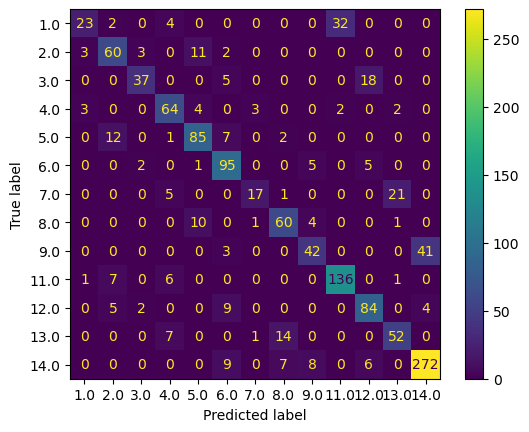

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()